In [2]:
%load_ext autoreload
%autoreload 2
%aimport mcfost
%matplotlib inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterExponent
from numpy import unravel_index
import astropy.units as unit
import pysynphot
import os
import math
from sh import gunzip

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def bandavg(file_dir):
    px=256
    py=256
    c=2.99792*10**14
    jy=10**26
    psf_scale=0.02182 ##arcsecs/pixel
    xpix=(np.arange ((-px/2), (px/2), 1))*psf_scale
    ypix=(np.arange ((-px/2), (px/2), 1))*psf_scale
    sq_as_per_pix=psf_scale**2
    model_in=mcfost.ModelResults(file_dir)
    wav=list(model_in._wavelengths_lookup.values())
    fig_path=file_dir+'band_avg.pdf'
    l=len(wav)
    figr=[]
    sst_band=np.zeros((256,256),dtype=float)
    I_band=np.zeros((256,256),dtype=float)
    Q_band=np.zeros((256,256),dtype=float)
    U_band=np.zeros((256,256),dtype=float)
    for i in range (l):
        im=model_in.images[wav[i]]
        lam=float(wav[i]) #in microns#
        
        I=np.reshape(im.data[0,0],(px,py))
        Q=np.reshape(im.data[1,0],(px,py))
        U=np.reshape(im.data[2,0],(px,py))
        sst=np.reshape(im.data[5,0],(px,py))
        
        sst_jy=(sst/c)*(lam**2)*jy
        sst_band=sst_band+sst_jy
        
        I_jy=(I/c)*(lam**2)*jy
        I_band=I_band+I_jy
        
        Q_jy=(Q/c)*(lam**2)*jy
        Q_band=Q_band+Q_jy
        
        U_jy=(U/c)*(lam**2)*jy
        U_band=U_band+U_jy
        
    sst_avg=sst_band/l
    I_avg=I_band/l
    Q_avg=Q_band/l
    U_avg=U_band/l
        
    hdu = fits.PrimaryHDU(sst_avg.astype(np.float64))
    hdul = fits.HDUList([hdu])
    hdul.writeto(file_dir+'sst_band.fits',overwrite=True)
    hdu = fits.PrimaryHDU(I_avg.astype(np.float64))
    hdul = fits.HDUList([hdu])
    hdul.writeto(file_dir+'I_band.fits',overwrite=True)
    hdu = fits.PrimaryHDU(Q_avg.astype(np.float64))
    hdul = fits.HDUList([hdu])
    hdul.writeto(file_dir+'Q_band.fits',overwrite=True)
    hdu = fits.PrimaryHDU(U_avg.astype(np.float64))
    hdul = fits.HDUList([hdu])
    hdul.writeto(file_dir+'U_band.fits',overwrite=True)
        
    fig = plt.figure(figsize=(25, 10))
    ax1=fig.add_subplot(141)
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.minorticks_on()
    ax1.tick_params(which='both', direction='in', width=0.5, labelsize=16)
    im1=ax1.imshow(I_avg.astype(np.float64)/1000,cmap='plasma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
    ax1.invert_yaxis()
    ax1.set_ylabel('arcsec',fontsize=18)
    ax1.set_xlabel('arcsec',fontsize=18)
    ax1.set_title('Star',fontsize=18)
    cb = fig.colorbar(im1,orientation='vertical',shrink=0.4)
    cb.set_label("mJy",fontsize=18)
    cb.ax.tick_params(labelsize=18)

    ax2=fig.add_subplot(142)
    ax2.yaxis.set_ticks_position('both')
    ax2.xaxis.set_ticks_position('both')
    ax2.minorticks_on()
    ax2.tick_params(which='both', direction='in', width=0.5, labelsize=16)
    im2=ax2.imshow(sst_avg.astype(np.float64)/sq_as_per_pix*1000,cmap='plasma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
    ax2.invert_yaxis()
    ax2.set_ylabel('arcsec',fontsize=18)
    ax2.set_xlabel('arcsec',fontsize=18)
    ax2.set_title('Scattered starlight',fontsize=18)
    cb = fig.colorbar(im2,orientation='vertical',shrink=0.4)
    cb.set_label("mJy/arcsec^2",fontsize=18)
    cb.ax.tick_params(labelsize=18)
        
    ax3=fig.add_subplot(143)
    ax3.yaxis.set_ticks_position('both')
    ax3.xaxis.set_ticks_position('both')
    ax3.minorticks_on()
    ax3.tick_params(which='both', direction='in', width=0.5, labelsize=16)
    im3=ax3.imshow(Q_avg.astype(np.float64)/sq_as_per_pix*1000,cmap='plasma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
    ax3.invert_yaxis()
    ax3.set_ylabel('arcsec',fontsize=18)
    ax3.set_xlabel('arcsec',fontsize=18)
    ax3.set_title('Q',fontsize=18)
    cb = fig.colorbar(im3,orientation='vertical',shrink=0.4)
    cb.set_label("mJy/arcsec^2",fontsize=18)
    cb.ax.tick_params(labelsize=18)

    ax4=fig.add_subplot(144)
    ax4.yaxis.set_ticks_position('both')
    ax4.xaxis.set_ticks_position('both')
    ax4.minorticks_on()
    ax4.tick_params(which='both', direction='in', width=0.5, labelsize=16)
    im4=ax4.imshow(U_avg.astype(np.float64)/sq_as_per_pix*1000,cmap='plasma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
    ax4.invert_yaxis()
    ax4.set_ylabel('arcsec',fontsize=18)
    ax4.set_xlabel('arcsec',fontsize=18)
    ax4.set_title('U',fontsize=18)
    cb = fig.colorbar(im4,orientation='vertical',shrink=0.4)
    cb.set_label("mJy/arcsec^2",fontsize=18)
    cb.ax.tick_params(labelsize=18)
        
    fig.subplots_adjust(hspace=0.1, wspace=0.45, top=0.9, right=0.95)
    fig.savefig(fig_path, format='pdf', bbox_inches='tight')
    figr.append(fig)
    return(figr)
        

In [4]:
main_dir='/Users/polaris/Onedrive-UA/OneDrive - University of Arizona/Debris-Disk-Modelling/Debris-Disk-Modelling/Eps-eri-Roman_pol/Simulations_paper/HLC_band_analog/'
dust='Astrosil/'
file_dir=main_dir+dust

/Users/polaris/opt/anaconda3/lib/python3.9/site-packages/mcfost-0.3-py3.9.egg/mcfost/models.py:185: UserWarning: No ray-traced SED results were found in that directory.


[<Figure size 2500x1000 with 8 Axes>]

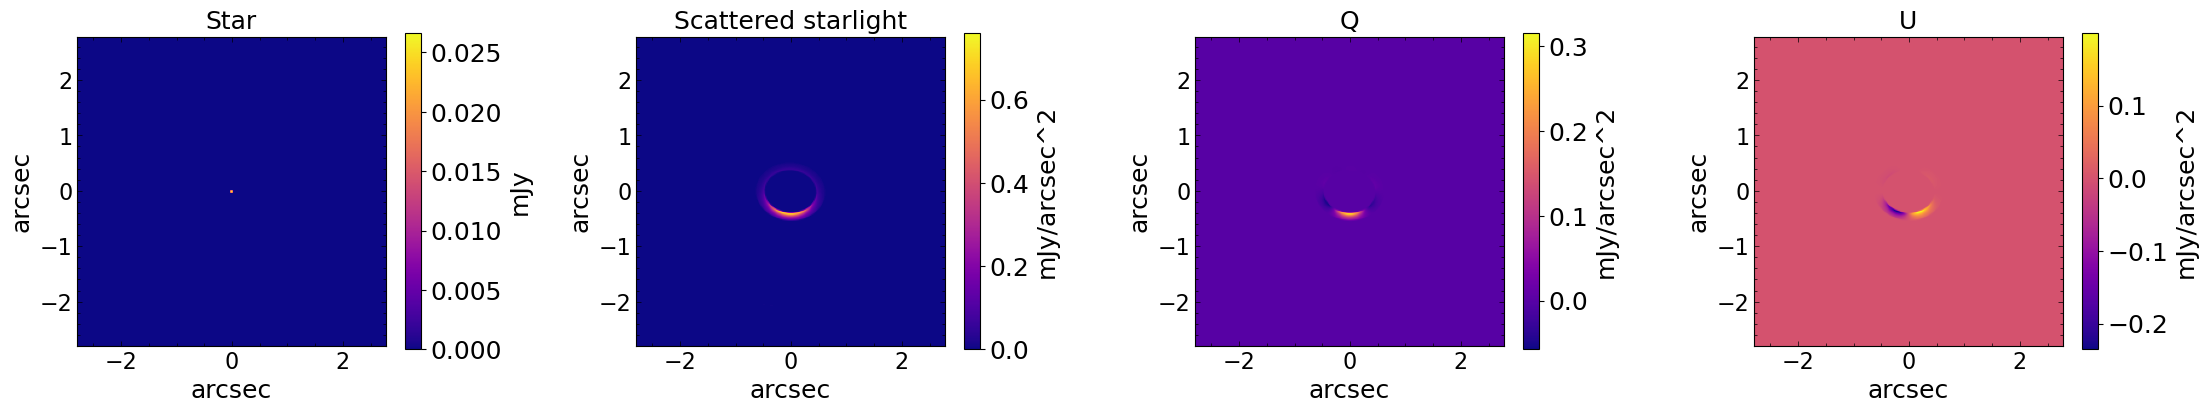

In [5]:
bandavg(file_dir)

In [6]:
px=py=256
psf_scale=0.02182 ##arcsecs/pixel
xpix=(np.arange ((-px/2)+96, (px/2)-96, 1))*psf_scale
ypix=(np.arange ((-px/2)+96, (px/2)-96, 1))*psf_scale
sq_as_per_pix=psf_scale**2

sst=fits.getdata(file_dir+'sst_band.fits')
Q=fits.getdata(file_dir+'Q_band.fits')
U=fits.getdata(file_dir+'U_band.fits')
nx=128-32
ny=128+32

In [7]:
q=Q/sst
u=U/sst
q[np.isnan(q)]=0
u[np.isnan(u)]=0
p=np.sqrt(q*q+u*u)
theta=0.5*np.arctan2(u,q)
theta[np.isnan(theta)]=0

/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_56105/2145170138.py:1: RuntimeWarning: invalid value encountered in true_divide
  q=Q/sst
/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_56105/2145170138.py:2: RuntimeWarning: invalid value encountered in true_divide
  u=U/sst


In [13]:
X, Y = np.mgrid[(0):(px):256j, (0):(px):256j]
positions = np.vstack([X.ravel(), Y.ravel()])
pos=np.transpose(positions)

Phi=np.arctan2((pos[:,0]-px/2),(pos[:,1]-px/2))
Phi_new=np.reshape(Phi,(px,px))

Q_phi=-(Q*np.cos(2*Phi_new)+U*np.sin(2*Phi_new))
U_phi=-Q*np.sin(2*Phi_new)+U*np.cos(2*Phi_new)
theta=0.5*np.arctan2(U,Q)

In [14]:
qx, qy=np.unravel_index(np.argmax(Q_phi), Q_phi.shape)
prx, pry =np.unravel_index(np.argmax(p), p.shape)
npix=2
p_r_lin   =np.mean(p[qx-npix:qx+npix,:],axis=0)
p_r_err  =np.mean(np.std(p[prx-npix:prx+npix,:],axis=0))

In [15]:
np.max(p_r_lin)

0.4251831318249856

In [16]:
p_r_err

0.005842197817915019

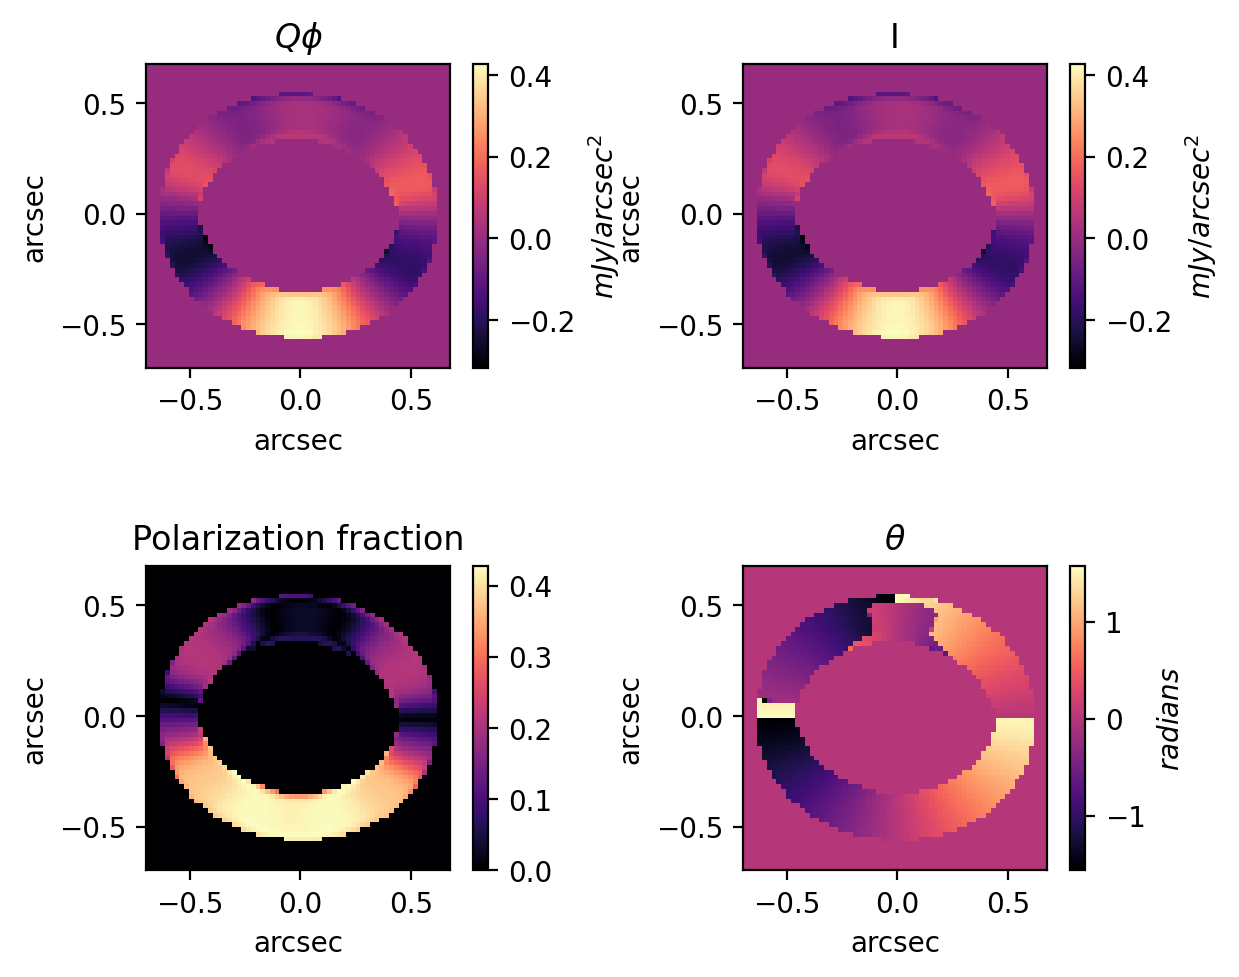

In [17]:
fig = plt.figure(dpi=200)
ax1=fig.add_subplot(221)
im1=ax1.imshow(q.astype(np.float64)[nx:ny,nx:ny],cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax1.invert_yaxis()
ax1.set_ylabel('arcsec')
ax1.set_xlabel('arcsec')
ax1.set_title(r'$Q\phi$')
#ax1.set_title('$Q$')
cb = fig.colorbar(im1,orientation='vertical')
cb.set_label("$mJy/arcsec^2$")
ax1.grid(False)

ax2=fig.add_subplot(222)
im2=ax2.imshow(q.astype(np.float64)[nx:ny,nx:ny],cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax2.invert_yaxis()
ax2.set_ylabel('arcsec')
ax2.set_xlabel('arcsec')
#ax2.set_title(r'$U\phi$')
ax2.set_title('I')
#ax2.set_title('$scattered~light$')
cb = fig.colorbar(im2,orientation='vertical')
cb.set_label("$mJy/arcsec^2$")
ax2.grid(False)


ax1=fig.add_subplot(223)
im1=ax1.imshow(p.astype(np.float64)[nx:ny,nx:ny],cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax1.invert_yaxis()
ax1.set_ylabel('arcsec')
ax1.set_xlabel('arcsec')
ax1.set_title('Polarization fraction')
cb = fig.colorbar(im1,orientation='vertical')
#cb.set_label("p")
ax1.grid(False)

ax1=fig.add_subplot(224)
im1=ax1.imshow(theta[nx:ny,nx:ny],cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax1.invert_yaxis()
ax1.set_ylabel('arcsec')
ax1.set_xlabel('arcsec')
ax1.set_title(r'$\theta$')
cb = fig.colorbar(im1,orientation='vertical')
cb.set_label("$radians$")
ax1.grid(False)
fig.subplots_adjust(hspace=0.65, wspace=0.30, top=0.95, right=0.95)

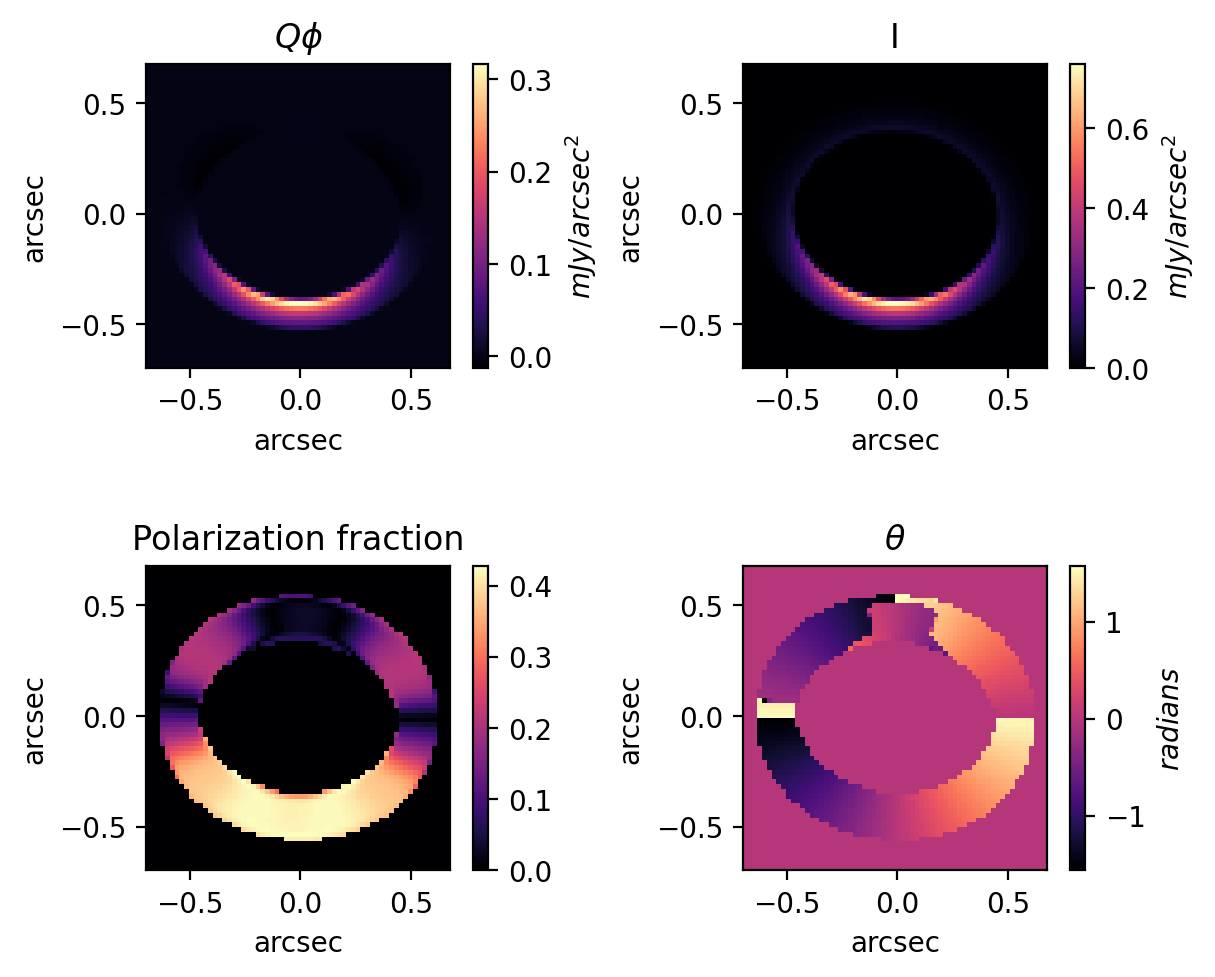

In [18]:
fig = plt.figure(dpi=200)
ax1=fig.add_subplot(221)
im1=ax1.imshow(Q_phi.astype(np.float64)[nx:ny,nx:ny]/sq_as_per_pix*1000,cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax1.invert_yaxis()
ax1.set_ylabel('arcsec')
ax1.set_xlabel('arcsec')
ax1.set_title(r'$Q\phi$')
#ax1.set_title('$Q$')
cb = fig.colorbar(im1,orientation='vertical')
cb.set_label("$mJy/arcsec^2$")
ax1.grid(False)

ax2=fig.add_subplot(222)
im2=ax2.imshow(sst.astype(np.float64)[nx:ny,nx:ny]/sq_as_per_pix*1000,cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax2.invert_yaxis()
ax2.set_ylabel('arcsec')
ax2.set_xlabel('arcsec')
#ax2.set_title(r'$U\phi$')
ax2.set_title('I')
#ax2.set_title('$scattered~light$')
cb = fig.colorbar(im2,orientation='vertical')
cb.set_label("$mJy/arcsec^2$")
ax2.grid(False)


ax1=fig.add_subplot(223)
im1=ax1.imshow(p.astype(np.float64)[nx:ny,nx:ny],cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax1.invert_yaxis()
ax1.set_ylabel('arcsec')
ax1.set_xlabel('arcsec')
ax1.set_title('Polarization fraction')
cb = fig.colorbar(im1,orientation='vertical')
#cb.set_label("p")
ax1.grid(False)

ax1=fig.add_subplot(224)
im1=ax1.imshow(theta[nx:ny,nx:ny],cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax1.invert_yaxis()
ax1.set_ylabel('arcsec')
ax1.set_xlabel('arcsec')
ax1.set_title(r'$\theta$')
cb = fig.colorbar(im1,orientation='vertical')
cb.set_label("$radians$")
ax1.grid(False)
fig.subplots_adjust(hspace=0.65, wspace=0.30, top=0.95, right=0.95)

In [21]:
#Roman IPAC estimations
# reference and target star from Os9
# ζ Pup V=2.25 
m_z=2.25
ph_z=9.39854e+08  #ph/s

#47 UMa, V=5.04
m_u=5.04
ph_u=8.24037e+07
# conversion to flux in Jy
F_z=3631*10**(m_z*(-0.4))
F_u=3631*10**(m_u*(-0.4))
# surface brightness calculation in mag/sqarcsec
SB=-2.5*np.log10(sst.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z

/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_56105/3898094262.py:14: RuntimeWarning: divide by zero encountered in log10
  SB=-2.5*np.log10(sst.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z


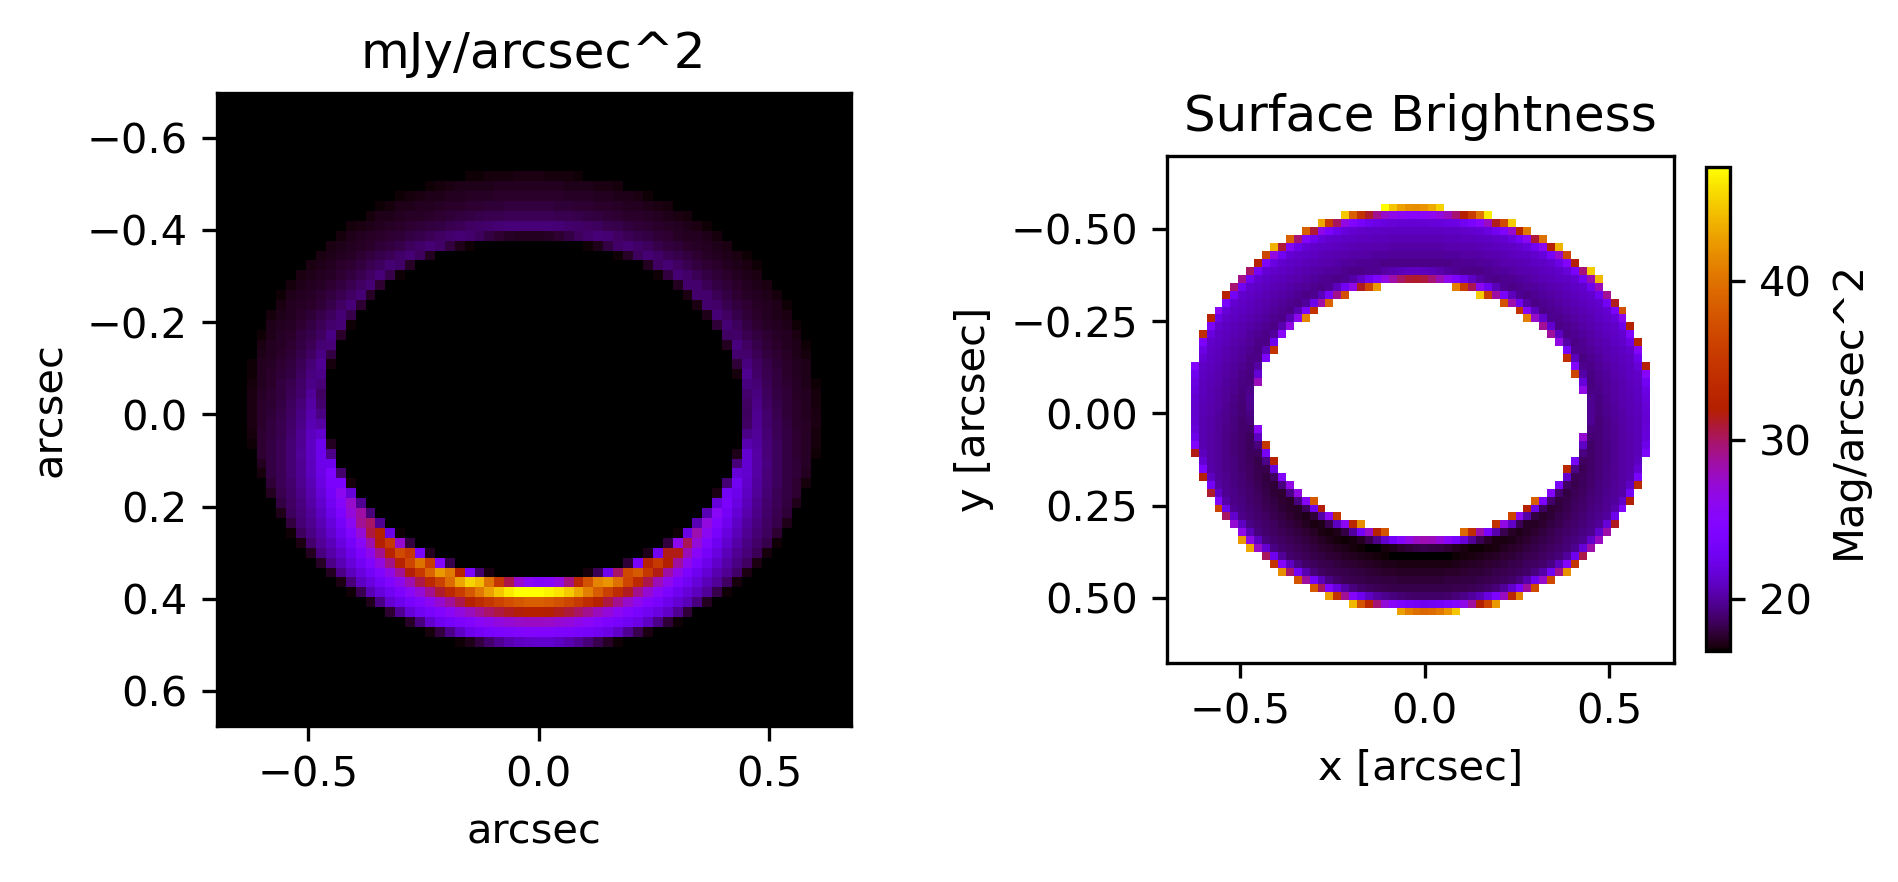

In [22]:
fig=plt.figure(dpi=300)
ax2=plt.subplot(121)
im2=ax2.imshow(sst.astype(np.float64)[nx:ny,nx:ny]/sq_as_per_pix*1000,
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.invert_yaxis()
ax2.set_ylabel('arcsec')
ax2.set_xlabel('arcsec')
ax2.set_title("mJy/arcsec^2")
#cb=plt.colorbar(im2,orientation='vertical',shrink=0.4)
#cb.set_label("mJy/arcsec^2")

ax2=plt.subplot(122)
im2=ax2.imshow(SB.astype(np.float64)[nx:ny,nx:ny],
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('Surface Brightness')
cb=plt.colorbar(im2,orientation='vertical',shrink=0.4)
cb.set_label("Mag/arcsec^2")
fig.subplots_adjust(hspace=0.65, wspace=0.5, top=0.95, right=0.95)


In [ ]:
Nphot=ph_z*10**(-0.4*(SB-m_z)) #sst_mag is in mag/arc^2

In [23]:
I0=(sst+Q)/2
I90=(sst-Q)/2
I45=(sst+U)/2
I135=(sst-U)/2

In [24]:
I0sb=-2.5*np.log10(I0.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z
I0ph=ph_z*10**(-0.4*(I0sb-m_z))

I90sb=-2.5*np.log10(I90.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z
I90ph=ph_z*10**(-0.4*(I90sb-m_z))

I45sb=-2.5*np.log10(I45.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z
I45ph=ph_z*10**(-0.4*(I45sb-m_z))

I135sb=-2.5*np.log10(I135.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z
I135ph=ph_z*10**(-0.4*(I135sb-m_z))

/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_56105/1463891641.py:1: RuntimeWarning: divide by zero encountered in log10
  I0sb=-2.5*np.log10(I0.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z
/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_56105/1463891641.py:4: RuntimeWarning: divide by zero encountered in log10
  I90sb=-2.5*np.log10(I90.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z
/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_56105/1463891641.py:7: RuntimeWarning: divide by zero encountered in log10
  I45sb=-2.5*np.log10(I45.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z
/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_56105/1463891641.py:10: RuntimeWarning: divide by zero encountered in log10
  I135sb=-2.5*np.log10(I135.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z


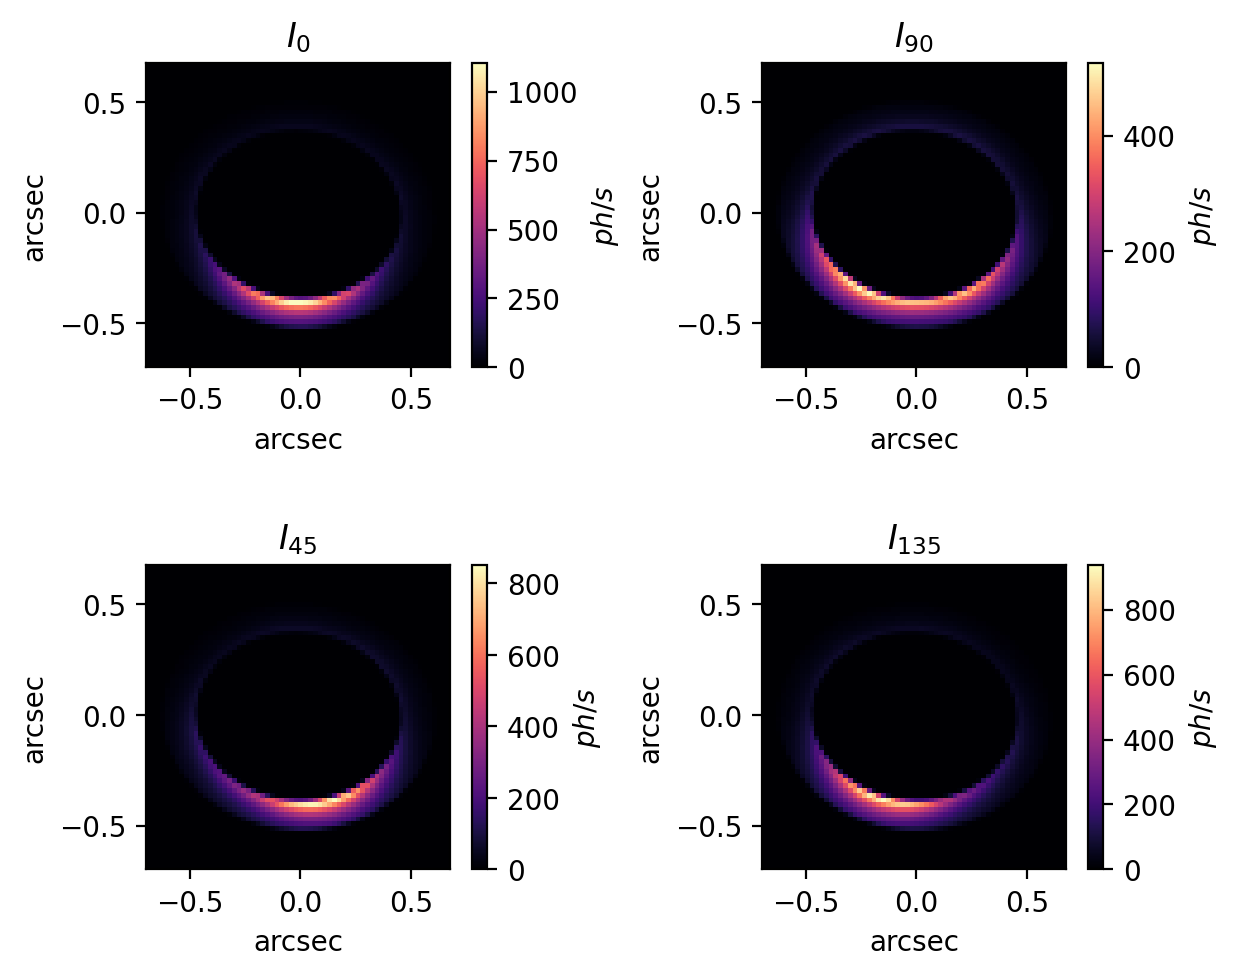

In [25]:
fig = plt.figure(dpi=200)
ax1=fig.add_subplot(221)
im1=ax1.imshow(I0ph[nx:ny,nx:ny],cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax1.invert_yaxis()
ax1.set_ylabel('arcsec')
ax1.set_xlabel('arcsec')
ax1.set_title('$I_{0}$')
cb = fig.colorbar(im1,orientation='vertical')
cb.set_label("$ph/s$")
ax1.grid(False)

ax2=fig.add_subplot(222)
im2=ax2.imshow(I90ph[nx:ny,nx:ny],cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax2.invert_yaxis()
ax2.set_ylabel('arcsec')
ax2.set_xlabel('arcsec')
ax2.set_title('$I_{90}$')
cb = fig.colorbar(im2,orientation='vertical')
cb.set_label("$ph/s$")
ax2.grid(False)

ax3=fig.add_subplot(223)
im3=ax3.imshow(I45ph[nx:ny,nx:ny],cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax3.invert_yaxis()
ax3.set_ylabel('arcsec')
ax3.set_xlabel('arcsec')
ax3.set_title('$I_{45}$')
cb = fig.colorbar(im3,orientation='vertical')
cb.set_label("$ph/s$")
ax3.grid(False)

ax4=fig.add_subplot(224)
im4=ax4.imshow(I135ph[nx:ny,nx:ny],cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax4.invert_yaxis()
ax4.set_ylabel('arcsec')
ax4.set_xlabel('arcsec')
ax4.set_title('$I_{135}$')
cb = fig.colorbar(im4,orientation='vertical')
cb.set_label("$ph/s$")
ax4.grid(False)
fig.subplots_adjust(hspace=0.65, wspace=0.4, top=0.95, right=0.95)

In [33]:
hdu = fits.PrimaryHDU(I0ph)
hdul = fits.HDUList([hdu])
hdul.writeto(file_dir+'I_0_hlc.fits',overwrite=True)
hdu = fits.PrimaryHDU(I90ph)
hdul = fits.HDUList([hdu])
hdul.writeto(file_dir+'I_90_hlc.fits',overwrite=True)
hdu = fits.PrimaryHDU(I45ph)
hdul = fits.HDUList([hdu])
hdul.writeto(file_dir+'I_45_hlc.fits',overwrite=True)
hdu = fits.PrimaryHDU(I135ph)
hdul = fits.HDUList([hdu])
hdul.writeto(file_dir+'I_135_hlc.fits',overwrite=True)